<a href="https://colab.research.google.com/github/riken-emar/LinkPredictionGNN/blob/main/GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#下記ブログを参考にGNNを行った。
#ノード分類,リンク予測
#https://cpp-learning.com/pytorch-geometric/#i-3

In [ ]:
import torch
print("PyTorch ==", torch.__version__)
print("CUDA available", torch.cuda.is_available())
print("CUDA ==", torch.version.cuda)

PyTorch == 1.13.0+cu116
CUDA available True
CUDA == 11.6


In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [ ]:
!pip install pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.13.0+cu116.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.0+cu116.html


In [ ]:
import torch
from torch_geometric.data import Data
 
# ノード
src = [0, 1, 2]  # 送信側
dst = [1, 2, 1]  # 受信側
 
# エッジ
edge_index = torch.tensor([src, dst], dtype=torch.long)
 
# ノードの特徴量
x0 = [1, 2]
x1 = [3, 4]
x2 = [5, 6]
x = torch.tensor([x0, x1, x2], dtype=torch.float)
 
# ラベル
y0 = [1]
y1 = [0]
y2 = [1]
y = torch.tensor([y0, y1, y2], dtype=torch.float)
 
data = Data(x=x, y=y, edge_index=edge_index)

In [ ]:
import torch
from torch_geometric.data import Data
 
# エッジ
edge_index = torch.tensor([[0, 1, 2],
                           [1, 2, 1]], dtype=torch.long)
 
# ノードの特徴量
x = torch.tensor([[1, 2], [3, 4], [5, 6]], dtype=torch.float)
 
# ラベル
y = torch.tensor([[1], [0], [1]], dtype=torch.float)
 
data = Data(x=x, y=y, edge_index=edge_index)

In [ ]:
def check_graph(data):
    '''グラフ情報を表示'''
    print("グラフ構造:", data)
    print("グラフのキー: ", data.keys)
    print("ノード数:", data.num_nodes)
    print("エッジ数:", data.num_edges)
    print("ノードの特徴量数:", data.num_node_features)
    print("孤立したノードの有無:", data.contains_isolated_nodes())
    print("自己ループの有無:", data.contains_self_loops())
    print("====== ノードの特徴量:x ======")
    print(data['x'])
    print("====== ノードのクラス:y ======")
    print(data['y'])
    print("========= エッジ形状 =========")
    print(data['edge_index'])

check_graph(data)

グラフ構造: Data(x=[3, 2], edge_index=[2, 3], y=[3, 1])
グラフのキー:  ['edge_index', 'y', 'x']
ノード数: 3
エッジ数: 3
ノードの特徴量数: 2
孤立したノードの有無: False
自己ループの有無: False
====== ノードの特徴量:x ======
tensor([[1., 2.],
        [3., 4.],
        [5., 6.]])
====== ノードのクラス:y ======
tensor([[1.],
        [0.],
        [1.]])
========= エッジ形状 =========
tensor([[0, 1, 2],
        [1, 2, 1]])


In [ ]:
import torch
import torch.nn.functional as F
 
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.datasets import KarateClub
# import torch_geometric.transforms as T
from torch_geometric.utils import to_networkx
 
import networkx as nx
from matplotlib import pyplot as plt
import numpy as np

In [ ]:
# データセットをダウンロード
dataset = KarateClub()
 
print("グラフ数:", len(dataset))  # グラフ数: 1
print("クラス数:",dataset.num_classes)  # クラス数: 2
 
data = dataset[0]  # 1つめのグラフ
check_graph(data)

グラフ数: 1
クラス数: 4
グラフ構造: Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
グラフのキー:  ['train_mask', 'edge_index', 'y', 'x']
ノード数: 34
エッジ数: 156
ノードの特徴量数: 34
孤立したノードの有無: False
自己ループの有無: False
====== ノードの特徴量:x ======
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])
====== ノードのクラス:y ======
tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])
========= エッジ形状 =========
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 

In [ ]:
!pip install --upgrade scipy networkx 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


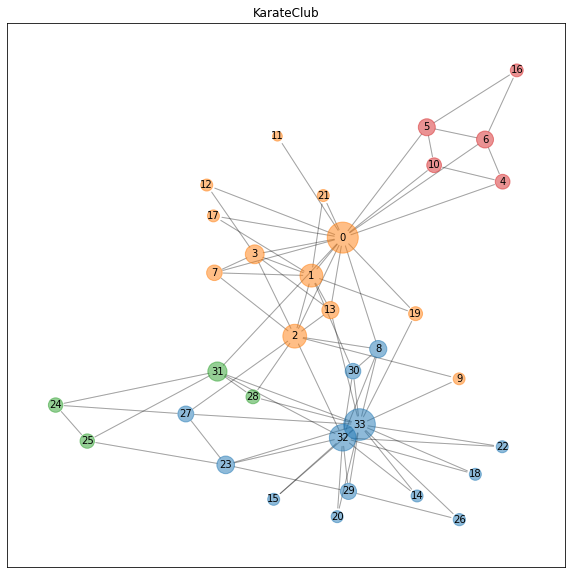

In [ ]:
# networkxのグラフに変換
nxg = to_networkx(data)
 
# 可視化のためのページランク計算
pr = nx.pagerank(nxg)
pr_max = np.array(list(pr.values())).max()
 
# 可視化する際のノード位置
draw_pos = nx.spring_layout(nxg, seed=0) 
 
# ノードの色設定
cmap = plt.get_cmap('tab10')
labels = data.y.numpy()
colors = [cmap(l) for l in labels]
 
# 図のサイズ
plt.figure(figsize=(10, 10))
 
# 描画
nx.draw_networkx_nodes(nxg, 
                       draw_pos,
                       node_size=[v / pr_max * 1000 for v in pr.values()],
                       node_color=colors, alpha=0.5)
nx.draw_networkx_edges(nxg, draw_pos, arrowstyle='-', alpha=0.2)
nx.draw_networkx_labels(nxg, draw_pos, font_size=10)
 
plt.title('KarateClub')
plt.show()

In [ ]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        hidden_size = 5
        self.conv1 = GCNConv(dataset.num_node_features, hidden_size)
        self.conv2 = GCNConv(hidden_size, dataset.num_classes)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        
        return F.log_softmax(x, dim=1)

In [ ]:
# デバイス設定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
 
# モデルのインスタンス生成
model = Net()
# print(model)
 
# モデルを訓練モードに設定
model.train()

Net(
  (conv1): GCNConv(34, 5)
  (conv2): GCNConv(5, 4)
)

In [ ]:
# input data
data = dataset[0]
 
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
 
# learnig loop
for epoch in range(100):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out, data.y)
    loss.backward()
    optimizer.step()
    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 1.3780
Epoch 1 | Loss: 1.3655
Epoch 2 | Loss: 1.3533
Epoch 3 | Loss: 1.3417
Epoch 4 | Loss: 1.3297
Epoch 5 | Loss: 1.3174
Epoch 6 | Loss: 1.3048
Epoch 7 | Loss: 1.2920
Epoch 8 | Loss: 1.2792
Epoch 9 | Loss: 1.2663
Epoch 10 | Loss: 1.2532
Epoch 11 | Loss: 1.2397
Epoch 12 | Loss: 1.2257
Epoch 13 | Loss: 1.2113
Epoch 14 | Loss: 1.1963
Epoch 15 | Loss: 1.1810
Epoch 16 | Loss: 1.1654
Epoch 17 | Loss: 1.1494
Epoch 18 | Loss: 1.1335
Epoch 19 | Loss: 1.1172
Epoch 20 | Loss: 1.1009
Epoch 21 | Loss: 1.0847
Epoch 22 | Loss: 1.0687
Epoch 23 | Loss: 1.0529
Epoch 24 | Loss: 1.0376
Epoch 25 | Loss: 1.0227
Epoch 26 | Loss: 1.0081
Epoch 27 | Loss: 0.9937
Epoch 28 | Loss: 0.9795
Epoch 29 | Loss: 0.9654
Epoch 30 | Loss: 0.9514
Epoch 31 | Loss: 0.9374
Epoch 32 | Loss: 0.9235
Epoch 33 | Loss: 0.9097
Epoch 34 | Loss: 0.8959
Epoch 35 | Loss: 0.8823
Epoch 36 | Loss: 0.8687
Epoch 37 | Loss: 0.8553
Epoch 38 | Loss: 0.8421
Epoch 39 | Loss: 0.8289
Epoch 40 | Loss: 0.8160
Epoch 41 | Loss: 0.8032
Ep

In [ ]:
data

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])

In [ ]:
# モデルを評価モードに設定
model.eval()
 
# 推論
_, pred = model(data).max(dim=1)
 
print("結果：", pred)
print("真値：", data["y"])

結果： tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 0, 0, 0, 0, 0, 0])
真値： tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])


In [ ]:
test_dataset = KarateClub()
test_data = test_dataset[0]
 
x = test_data["x"]
edge_index = test_data['edge_index']
 
# change link of ID:0, ID:2, ID:8, ID:9 and ID:33
edge_index[1][61] = 0  # 「ノード9⇒ノード2」から「ノード9⇒ノード0」にリンク変更
edge_index[1][7] = 9   # 「ノード0⇒ノード8」から「ノード0⇒ノード9」にリンク変更
edge_index[1][56] = 9   # 「ノード8⇒ノード0」から「ノード8⇒ノード9」にリンク変更
edge_index[1][62] = 8   # 「ノード9⇒ノード33」から「ノード9⇒ノード8」にリンク変更
edge_index[1][140] = 2  # 「ノード33⇒ノード9」から「ノード33⇒ノード2」にリンク変更
edge_index[1][30] = 33  # 「ノード2⇒ノード9」から「ノード2⇒ノード33」にリンク変更
 
t_data = Data(x=x, edge_index=edge_index, y=y)
check_graph(t_data)

グラフ構造: Data(x=[34, 34], edge_index=[2, 156], y=[3, 1])
グラフのキー:  ['edge_index', 'y', 'x']
ノード数: 34
エッジ数: 156
ノードの特徴量数: 34
孤立したノードの有無: False
自己ループの有無: False
====== ノードの特徴量:x ======
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])
====== ノードのクラス:y ======
tensor([[1.],
        [0.],
        [1.]])
========= エッジ形状 =========
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 

/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'contains_isolated_nodes' is deprecated, use 'has_isolated_nodes' instead
  warnings.warn(out)
/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'contains_self_loops' is deprecated, use 'has_self_loops' instead
  warnings.warn(out)


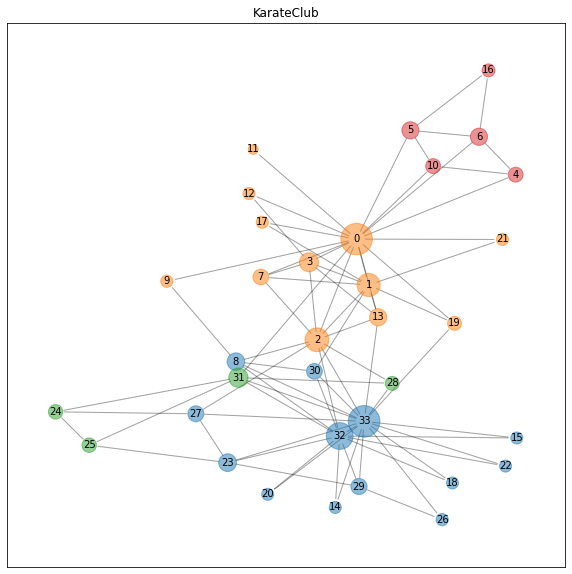

In [ ]:
# networkxのグラフに変換
nxg = to_networkx(t_data)
 
# 可視化のためのページランク計算
pr = nx.pagerank(nxg)
pr_max = np.array(list(pr.values())).max()
 
# 可視化する際のノード位置
draw_pos = nx.spring_layout(nxg, seed=0) 
 
# ノードの色設定
cmap = plt.get_cmap('tab10')
labels = data.y.numpy()
colors = [cmap(l) for l in labels]
 
# 図のサイズ
plt.figure(figsize=(10, 10))
 
# 描画
nx.draw_networkx_nodes(nxg, 
                       draw_pos,
                       node_size=[v / pr_max * 1000 for v in pr.values()],
                       node_color=colors, alpha=0.5)
nx.draw_networkx_edges(nxg, draw_pos, arrowstyle='-', alpha=0.2)
nx.draw_networkx_labels(nxg, draw_pos, font_size=10)
 
plt.title('KarateClub')
plt.show()

In [ ]:
model.eval() #モデルを評価モードにする。
_, pred = model(t_data).max(dim=1)
 
print(" ======== リンク変更前のラベル ======== ")
print(data["y"])
print(" ==== リンク変更後のラベル予測結果 ==== ")
print(pred)

 ======== リンク変更前のラベル ======== 
tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])
 ==== リンク変更後のラベル予測結果 ==== 
tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 0, 0, 0, 0, 0, 0])


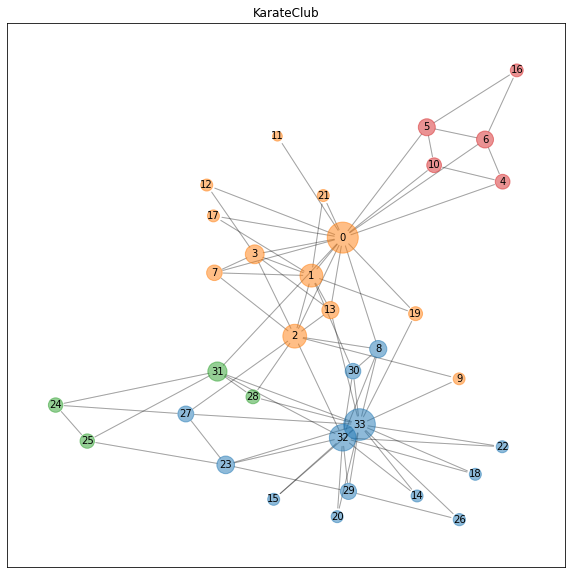

In [ ]:
# networkxのグラフに変換
nxg = to_networkx(data)
 
# 可視化のためのページランク計算
pr = nx.pagerank(nxg)
pr_max = np.array(list(pr.values())).max()
 
# 可視化する際のノード位置
draw_pos = nx.spring_layout(nxg, seed=0) 
 
# ノードの色設定
cmap = plt.get_cmap('tab10')
labels = data.y.numpy()
colors = [cmap(l) for l in labels]
 
# 図のサイズ
plt.figure(figsize=(10, 10))
 
# 描画
nx.draw_networkx_nodes(nxg, 
                       draw_pos,
                       node_size=[v / pr_max * 1000 for v in pr.values()],
                       node_color=colors, alpha=0.5)
nx.draw_networkx_edges(nxg, draw_pos, arrowstyle='-', alpha=0.2)
nx.draw_networkx_labels(nxg, draw_pos, font_size=10)
 
plt.title('KarateClub')
plt.show()